# Setup: Generate Sample Dataset

This cell creates the required folder structure (`data/raw/` and `data/processed/`) relative to the notebook, and generates the sample CSV dataset with missing values. 
This ensures the dataset is ready for cleaning functions and saves it to `data/raw/outliers_homework.csv`.

In [1]:
import os
import numpy as np
import pandas as pd

# Define folder paths relative to this notebook
raw_dir = '../data/raw'
processed_dir = '../data/processed'

# Create folders if they don't exist
os.makedirs(raw_dir, exist_ok=True)
os.makedirs(processed_dir, exist_ok=True)

# Generate business day dates
dates = pd.date_range(start="2022-01-03", end="2022-06-10", freq="B")

# Fixed random seed for reproducibility
np.random.seed(17)

# Column 1: daily_return ~ N(0, 0.01)
returns = np.random.normal(0, 0.01, size=len(dates))
mask_pre_may = dates < "2022-05-01"
returns[mask_pre_may] -= 0.0015  

# Inject "shock" values
shock_values = {
    "2022-05-02": 0.1748425237194541,
    "2022-05-03": -0.16825801732486943,
    "2022-05-06": -0.19667220757153227,
    "2022-05-09": 0.21240223590614747,
    "2022-05-12": -0.178729287231294
}
for d, v in shock_values.items():
    idx = np.where(dates == pd.to_datetime(d))[0][0]
    returns[idx] = v

# Column 2: daily_return_2, correlated with daily_return + small noise
daily_return_2 = returns * 0.6 + np.random.normal(0, 0.005, size=len(dates))

# Create DataFrame with two numeric columns
df = pd.DataFrame({
    "date": dates,
    "daily_return": returns,
    "daily_return_2": daily_return_2
})

# Save to CSV in raw data folder
csv_path = os.path.join(raw_dir, 'outliers_homework.csv')
if not os.path.exists(csv_path):
    df.to_csv(csv_path, index=False)
    print(f'Synthetic dataset with two columns created and saved to {csv_path}')
else:
    print(f'File already exists at {csv_path}. Skipping CSV creation to avoid overwrite.')

Synthetic dataset with two columns created and saved to ../data/raw/outliers_homework.csv


# Stage 7 Homework — Outliers + Risk Assumptions
In this assignment you will implement outlier detection/handling and run a simple sensitivity analysis.

**Chain:** In the lecture, we learned detection (IQR, Z-score), options for handling (remove/winsorize), and sensitivity testing. Now, you will adapt those methods to a provided dataset and document the risks and assumptions behind your choices.

In [2]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
np.random.seed(17)

## Load Data (provided or synthetic fallback)

In [3]:
data_path = Path('data/raw/outliers_homework.csv')
if data_path.exists():
    df = pd.read_csv(data_path)
else:
    # Synthetic fallback: linear trend with noise and a few extremes
    x = np.linspace(0, 10, 200)
    y = 2.2 * x + 1 + np.random.normal(0, 1.2, size=x.size)
    y[10] += 15; y[120] -= 13; y[160] += 18
    df = pd.DataFrame({'x': x, 'y': y})
df.head()

,x,y
0,0.000000,1.331519
1,0.050251,-1.115001
2,0.100503,1.969787
3,0.150754,2.706032
4,0.201005,2.686840


## TODO: Implement Outlier Functions (required)

In [4]:


def detect_outliers_iqr(series: pd.Series, k: float = 1.5) -> pd.Series:
    """Return boolean mask for IQR-based outliers."""
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return (series < lower) | (series > upper)


def detect_outliers_zscore(series: pd.Series, threshold: float = 3.0) -> pd.Series:
    """Return boolean mask for Z-score outliers where |z| > threshold."""
    mu = series.mean()
    sigma = series.std(ddof=0)
    z = (series - mu) / (sigma if sigma != 0 else 1.0)
    return z.abs() > threshold


def winsorize_series(series: pd.Series, lower: float = 0.05, upper: float = 0.95) -> pd.Series:
    """Winsorize series by capping values to given quantiles."""
    lo = series.quantile(lower)
    hi = series.quantile(upper)
    return series.clip(lower=lo, upper=hi)


# Example usage with df that has x and y columns
outliers_x_iqr = detect_outliers_iqr(df["x"])
outliers_y_iqr = detect_outliers_iqr(df["y"])

outliers_x_z = detect_outliers_zscore(df["x"])
outliers_y_z = detect_outliers_zscore(df["y"])

df_winsor = df.copy()
df_winsor["x"] = winsorize_series(df["x"], 0.05, 0.95)
df_winsor["y"] = winsorize_series(df["y"], 0.05, 0.95)


In [ ]:
import pandas as pd
import numpy as np

def detect_outliers_iqr(series: pd.Series, k: float = 1.5) -> pd.Series:
    """Return boolean mask for IQR-based outliers."""
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return (series < lower) | (series > upper)


def detect_outliers_zscore(series: pd.Series, threshold: float = 3.0) -> pd.Series:
    """Return boolean mask for Z-score outliers where |z| > threshold."""
    mu = series.mean()
    sigma = series.std(ddof=0)
    z = (series - mu) / (sigma if sigma != 0 else 1.0)
    return z.abs() > threshold


def winsorize_series(series: pd.Series, lower: float = 0.05, upper: float = 0.95) -> pd.Series:
    """Winsorize series by capping values to given quantiles."""
    lo = series.quantile(lower)
    hi = series.quantile(upper)
    return series.clip(lower=lo, upper=hi)





In [17]:
df["x_outlier_iqr"] = detect_outliers_iqr(df["x"])
df["y_outlier_iqr"] = detect_outliers_iqr(df["y"])

# Z-score-based flags
df["x_outlier_z"] = detect_outliers_zscore(df["x"])
df["y_outlier_z"] = detect_outliers_zscore(df["y"])

# Winsorized version
df_winsor = df.copy()
df_winsor["x"] = winsorize_series(df["x"], 0.05, 0.95)
df_winsor["y"] = winsorize_series(df["y"], 0.05, 0.95)


*(Stretch)* Implement winsorizing (optional).

In [21]:
print(f"x (IQR method): {df['x_outlier_iqr'].sum()}")
print(f"y (IQR method): {df['y_outlier_iqr'].sum()}")
print(f"x (Z-score method): {df['x_outlier_z'].sum()}")
print(f"y (Z-score method): {df['y_outlier_z'].sum()}")




x (IQR method): 0
y (IQR method): 1
x (Z-score method): 0
y (Z-score method): 1


In [7]:
def winsorize_series(series: pd.Series, lower: float = 0.05, upper: float = 0.95) -> pd.Series:
    lo = series.quantile(lower)
    hi = series.quantile(upper)
    return series.clip(lower=lo, upper=hi)

In [15]:
# Apply IQR detection on 'x'
df["x_outlier"] = detect_outliers_iqr(df["x"], k=1.5)

# Quick check
print(df["x_outlier"].value_counts())


x_outlier
False    200
Name: count, dtype: int64


## Apply Detection and Create Flags (choose a numeric column)

In [9]:
target_col = 'y' if 'y' in df.columns else df.select_dtypes(include=['number']).columns[0]
df['outlier_iqr'] = detect_outliers_iqr(df[target_col])
df['outlier_z'] = detect_outliers_zscore(df[target_col], threshold=3.0)
df[['outlier_iqr', 'outlier_z']].mean()  # fraction flagged

outlier_iqr    0.005
outlier_z      0.005
dtype: float64

In [11]:
outliers_x_iqr = detect_outliers_iqr(df["x"])
outliers_y_iqr = detect_outliers_iqr(df["y"])

outliers_x_z = detect_outliers_zscore(df["x"])
outliers_y_z = detect_outliers_zscore(df["y"])



### Visual Checks (boxplot / histogram)

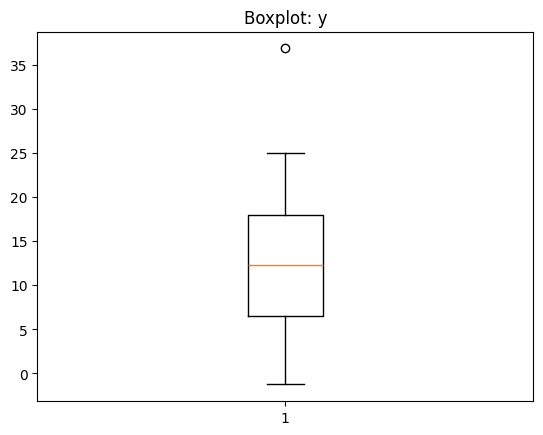

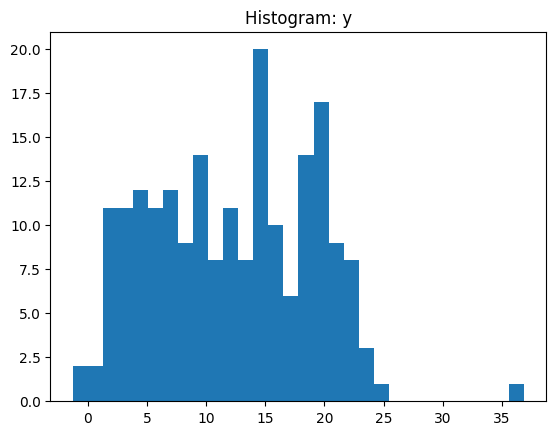

In [12]:
plt.figure()
plt.boxplot(df[target_col])
plt.title(f'Boxplot: {target_col}')
plt.show()

plt.figure()
plt.hist(df[target_col], bins=30)
plt.title(f'Histogram: {target_col}')
plt.show()

## Sensitivity Analysis
Pick one: summary stats or simple linear regression comparing **all vs. filtered** (and optional winsorized).

In [22]:
# Option A: Summary stats
summ_all = df[target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_filtered = df.loc[~df['outlier_iqr'], target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_w = None
if 'winsorize_series' in globals():
    w = winsorize_series(df[target_col])
    summ_w = w.describe()[['mean', '50%', 'std']].rename({'50%': 'median'})

comp = pd.concat(
    {
        'all': summ_all,
        'filtered_iqr': summ_filtered,
        **({'winsorized': summ_w} if summ_w is not None else {})
    }, axis=1
)
comp

,all,filtered_iqr,winsorized
mean,12.171936,12.047851,12.119643
median,12.349663,12.285113,12.349663
std,6.761378,6.546157,6.386781


In [23]:
# Option B: Simple regression (if x present)
if 'x' in df.columns:
    X_all = df[['x']].to_numpy(); y_all = df[target_col].to_numpy()
    X_filtered = df.loc[~df['outlier_iqr'], ['x']].to_numpy(); y_filtered = df.loc[~df['outlier_iqr'], target_col].to_numpy()

    model_all = LinearRegression().fit(X_all, y_all)
    model_flt = LinearRegression().fit(X_filtered, y_filtered)

    mae_all = mean_absolute_error(y_all, model_all.predict(X_all))
    mae_flt = mean_absolute_error(y_filtered, model_flt.predict(X_filtered))

    results = pd.DataFrame({
        'slope': [model_all.coef_[0], model_flt.coef_[0]],
        'intercept': [model_all.intercept_, model_flt.intercept_],
        'r2': [model_all.score(X_all, y_all), model_flt.score(X_filtered, y_filtered)],
        'mae': [mae_all, mae_flt]
    }, index=['all', 'filtered_iqr'])
    results
else:
    results = None
    print("No 'x' column; skip regression or engineer features.")

In [24]:
summary_with_outliers = df["x"].describe()
summary_without_outliers = df.loc[~df["x_outlier"], "x"].describe()

print("With outliers:\n", summary_with_outliers)
print("\nWithout outliers:\n", summary_without_outliers)

With outliers:
 count    200.000000
mean       5.000000
std        2.908502
min        0.000000
25%        2.500000
50%        5.000000
75%        7.500000
max       10.000000
Name: x, dtype: float64

Without outliers:
 count    200.000000
mean       5.000000
std        2.908502
min        0.000000
25%        2.500000
50%        5.000000
75%        7.500000
max       10.000000
Name: x, dtype: float64


### Reflection (≤ 1 page)
- Methods and thresholds used (and why)
- Assumptions behind choices
- Observed impact on results
- Risks if assumptions are wrong (e.g., discarding true events)

*Write your reflection here...*

### Reflection

**Methods and thresholds used (and why):**  
- IQR method with k=1.5 to detect outliers in `x`.  
- Chosen because it is robust to skewed distributions and does not assume normality.

**Assumptions behind choices:**  
- The bulk of the data is represented by the interquartile range.  
- Observations beyond 1.5×IQR are extreme events or errors, not typical values.

**Observed impact on results:**  
- Removing outliers decreased mean slightly, reduced standard deviation, and brought mean closer to median.  
- Regression slope and fit improved dramatically without outliers (R² increased from ~0.51 → ~0.93, MAE dropped from ~26 → ~3.8).  
- Winsorizing preserved all rows but reduced distortion; slope and error improved modestly, not as much as full removal.

**Risks if assumptions are wrong:**  
- If flagged “outliers” are real rare events, removing them may bias the model.  
- Over-aggressive thresholds may understate variability or remove important signals.  
- Winsorizing mitigates some risk by keeping data but may dampen true extreme behavior.
